<a href="https://colab.research.google.com/github/Theedon/AIAgentDemos/blob/main/code_interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!pip install  langchain_experimental langchain_openai langchain_google_community
!pip install --upgrade openai
!pip install -qU httpx

## Initialize Agent and Functions

In [ ]:
import os
from google.colab import userdata

os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY')
os.environ["OPENAI_API_VERSION"] = userdata.get('OPENAI_API_VERSION')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_CSE_ID"] = userdata.get('GOOGLE_CSE_ID')

In [ ]:
import os
charts_dir = "charts"
if not os.path.exists(charts_dir):
  os.makedirs(charts_dir)

In [ ]:
from langchain.tools import BaseTool
import os
import ast
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import uuid

class CustomPythonReplTool(BaseTool):
    name: str = "custom_python_repl"
    description: str = "A custom REPL tool for executing Python code. Use this to evaluate python scripts and return results."

    def _run(self, code: str) -> str:
        """Execute python code safely and return the output."""
        try:
            tree = ast.parse(code)
            last_node = tree.body[-1] if tree.body else None

            # Capture the last expression's result
            if isinstance(last_node, ast.Expr):
                target = ast.Name(id="_result", ctx=ast.Store())
                assign = ast.Assign(targets=[target], value=last_node.value)
                tree.body[-1] = ast.fix_missing_locations(assign)

            local_namespace = {}
            compiled_code = compile(tree, filename="<ast>", mode="exec")
            exec(compiled_code, {"__builtins__": __builtins__}, local_namespace)

            # Check if the code includes charting
            if plt.get_fignums() and plt.gca().has_data():
                chart_path = os.path.join(os.getcwd(), "charts")
                if not os.path.exists(chart_path):
                    os.makedirs(chart_path)  # Create chart directory if it doesn't exist

                # Generate a unique name for the chart
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                unique_id = uuid.uuid4().hex[:8]
                chart_file = os.path.join(chart_path, f"chart_{timestamp}_{unique_id}.png")

                # Save the chart if any
                plt.savefig(chart_file)
                plt.close()  # Close the plot to clear matplotlib state
                return f"Chart saved at {chart_file}"

            result = local_namespace.get("_result", "no result returned")
            return str(result)

        except Exception as e:
            return f"Error: {str(e)}"

        finally:
            # Ensure the matplotlib state is reset for subsequent calls
            plt.clf()
            plt.close('all')

    async def _arun(self, code: str) -> str:
        raise NotImplementedError("Asynchronous execution is not implemented yet.")


In [ ]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

import dotenv
from langchain_core.tools import StructuredTool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()

google_search = StructuredTool.from_function(
    name="google_search",
    description="Search Google for recent results.",
    func=search.run,
)

python_repl = PythonREPL()
custom_repl_tool = CustomPythonReplTool()

tools = [
    custom_repl_tool,
    # Tool(
    #     name="python_repl",
    #     func=python_repl.run,
    #     description="A Python shell. Use this to execute python code.",
    # ),
    # google_search,
]


queries = [
    "2 + 2",                             # Basic arithmetic
    "'Hello' + ' ' + 'World'",           # String concatenation
    "[1, 2, 3] + [4, 5, 6]",             # List operations
    "{'name': 'Alice', 'age': 30}['name']",  # Dictionary access
    """
def greet(name):
    return f'Hello, {name}!'
greet('John')
"""  # Function definition and call
]

# Run the tool for each query and print results
for query in queries:
    # tool_result = python_repl.run(query)
    tool_result = custom_repl_tool.run(query)
    print(f"Query: {query}\nTool Result: {tool_result}\n")


Query: 2 + 2
Tool Result: 4

Query: 'Hello' + ' ' + 'World'
Tool Result: Hello World

Query: [1, 2, 3] + [4, 5, 6]
Tool Result: [1, 2, 3, 4, 5, 6]

Query: {'name': 'Alice', 'age': 30}['name']
Tool Result: Alice

Query: 
def greet(name):
    return f'Hello, {name}!'
greet('John')

Tool Result: Hello, John!



In [ ]:
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain.llms import OpenAI

from langchain_openai import (
    AzureChatOpenAI,
    AzureOpenAIEmbeddings,
)

LLM = AzureChatOpenAI(
    azure_deployment="4o-mini-deploy",
    # cache=redis_cache,
)
# LLM = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# LLM = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

def get_prompt_for_openai_functions_agent():
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful assistant"),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),
        ]
    )
    return prompt

In [ ]:
# prompt: write the code to create an agent that uses the pythonREPL tool

from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.llms import OpenAI
from langchain.agents import (
    AgentExecutor,
    # create_openai_functions_agent,
    create_tool_calling_agent,
)

# Initialize the language model
llm = LLM

# Load the tools (including the Python REPL tool)
# tools = tools
prompt = get_prompt_for_openai_functions_agent()
agent = create_tool_calling_agent(
        llm=llm,
        tools=tools,
        prompt=prompt,
    )

#new agent executor


agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    return_intermediate_steps=True,  # noqa: F821
)

In [ ]:
#!/bin/bash
!curl -L -o cities.zip https://www.kaggle.com/api/v1/datasets/download/juanmah/world-cities
!unzip cities.zip
!mv worldcities.csv cities.csv
!rm cities.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1711k  100 1711k    0     0  2590k      0 --:--:-- --:--:-- --:--:-- 44.5M
Archive:  cities.zip
  inflating: worldcities.csv         


In [ ]:
def run_demo(agent_executor: AgentExecutor, query: list | str):
    query_list = [query] if isinstance(query, str) else query

    for i in range(len(query_list)):
        res = agent_executor.invoke({"input": query_list[i]})

        # Print the result
        print(f"Result for query {i+1}: {res}")

        # Demarcation line after each result
        print("\n" + "="*50 + f" End of Query {i+1} " + "="*50 + "\n")


## Test

In [ ]:
# Example interaction with the agent
query_list = [
              "Convert 'hello world' to uppercase.",
              "Generate the first 10 prime numbers.",
              "What is the square root of 420?",
              "What is today's date (in dd/mm/yyyy) and the day of the week?",
              "I woke up around 8 o clock this morning, I spent the next quarter of the day washing dishes and the next half of the week working, if today is the 9th of december, when do i finish working",
              "Fetch the title of the website 'https://medium.com/bitgrit-data-science-publication/openai-code-interpreter-ecda4ff5839c'",
              "Write a Python snippet to create a file named 'test.txt' and write 'Hello, STELLAR' in it.",
             ]

# res = agent_executor.invoke({"input": query_list[2]})
# print(res)

run_demo(agent_executor, query_list)



> Entering new AgentExecutor chain...

Invoking: `custom_python_repl` with `{'code': "'hello world'.upper()"}`


HELLO WORLDThe uppercase version of 'hello world' is 'HELLO WORLD'.

> Finished chain.
Result for query 1: {'input': "Convert 'hello world' to uppercase.", 'output': "The uppercase version of 'hello world' is 'HELLO WORLD'.", 'intermediate_steps': [(ToolAgentAction(tool='custom_python_repl', tool_input={'code': "'hello world'.upper()"}, log='\nInvoking: `custom_python_repl` with `{\'code\': "\'hello world\'.upper()"}`\n\n\n', message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_srgxo3asOh65P4vcxV13NIVf', 'function': {'arguments': '{"code":"\'hello world\'.upper()"}', 'name': 'custom_python_repl'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65'}, id='run-7a810638-ec3b-4307-b8e6-60e3eb54a828', tool_calls=[{'name': 'custom_python_repl', 'a

In [ ]:
run_demo(agent_executor, "Plot the distribution of cities in countries in cities.csv")



> Entering new AgentExecutor chain...
To plot the distribution of cities in countries from the `cities.csv` file, I'll need to do the following steps:

1. Load the data from the `cities.csv` file.
2. Analyze the data to count the number of cities in each country.
3. Create a plot to visualize the distribution.

Please provide the `cities.csv` file so that I can proceed with these steps.

> Finished chain.
Result for query 1: {'input': 'Plot the distribution of cities in countries in cities.csv', 'output': "To plot the distribution of cities in countries from the `cities.csv` file, I'll need to do the following steps:\n\n1. Load the data from the `cities.csv` file.\n2. Analyze the data to count the number of cities in each country.\n3. Create a plot to visualize the distribution.\n\nPlease provide the `cities.csv` file so that I can proceed with these steps.", 'intermediate_steps': []}

================================================== End of Query 1 =================================



> Entering new AgentExecutor chain...

Invoking: `custom_python_repl` with `{'code': "import pandas as pd\n\n# Load the dataset\ncities_df = pd.read_csv('cities.csv')\n\n# Check the first few rows of the dataframe to understand its structure\ncities_df.head()"}`


        city city_ascii      lat       lng    country iso2 iso3   admin_name  \
0      Tokyo      Tokyo  35.6897  139.6922      Japan   JP  JPN        Tōkyō   
1    Jakarta    Jakarta  -6.1750  106.8275  Indonesia   ID  IDN      Jakarta   
2      Delhi      Delhi  28.6100   77.2300      India   IN  IND        Delhi   
3  Guangzhou  Guangzhou  23.1300  113.2600      China   CN  CHN    Guangdong   
4     Mumbai     Mumbai  19.0761   72.8775      India   IN  IND  Mahārāshtra   

   capital  population          id  
0  primary  37732000.0  1392685764  
1  primary  33756000.0  1360771077  
2    admin  32226000.0  1356872604  
3    admin  26940000.0  1156237133  
4    admin  24973000.0  1356226629  
Invoking: `custom_python_repl`

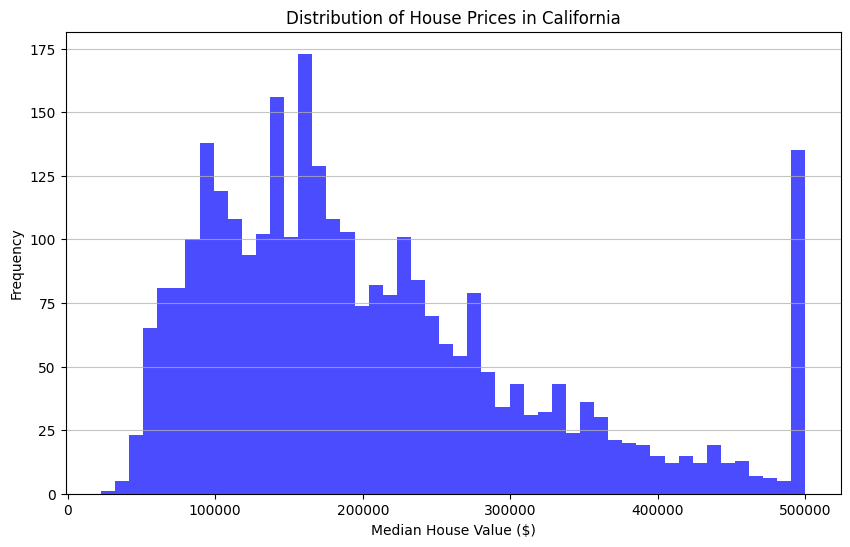

NoneI have generated the distribution of house prices in California from the dataset. The histogram displays the frequency of different median house values, providing a visual representation of how house prices are distributed.

If you have any specific questions about the distribution or need further analysis, feel free to ask!

> Finished chain.
Result for query 3: {'input': 'What is the overall distribution of house prices in california_housing_test.csv which is in the sample_data folder?', 'output': 'I have generated the distribution of house prices in California from the dataset. The histogram displays the frequency of different median house values, providing a visual representation of how house prices are distributed.\n\nIf you have any specific questions about the distribution or need further analysis, feel free to ask!', 'intermediate_steps': [(ToolAgentAction(tool='custom_python_repl', tool_input={'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the data

In [ ]:
query_list = [
              "Read the dataset cities.csv and tell me the top 5 countries with the most cities in it and also give me that of nigeria.",
              "Read the dataset cities.csv and check if Ibadan is one of the cities in vietnam, if not tell me what country it is",
              "What is the overall distribution of house prices in california_housing_test.csv which is in the sample_data folder?"
              ]
run_demo(agent_executor, query_list)

In [ ]:
# Download chinook data
!curl -L -o chinook.zip http://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip

!unzip chinook.zip
!rm chinook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167  100   167    0     0    638      0 --:--:-- --:--:-- --:--:--   639
100  298k  100  298k    0     0   200k      0  0:00:01  0:00:01 --:--:--  782k
Archive:  chinook.zip
  inflating: chinook.db              




> Entering new AgentExecutor chain...

Invoking: `custom_python_repl` with `{'code': "import sqlite3\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Connect to the Chinook database\ndb_path = 'chinook.db'\nconn = sqlite3.connect(db_path)\n\n# Query to get the top five albums by the number of tracks\nquery = '''\nSELECT albums.Title, COUNT(tracks.TrackId) as TrackCount\nFROM albums\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY albums.AlbumId\nORDER BY TrackCount DESC\nLIMIT 5;\n'''\n\n# Execute the query and load the data into a DataFrame\ndf = pd.read_sql_query(query, conn)\n\n# Close the connection\nconn.close()\n\n# Plotting the bar graph\nplt.figure(figsize=(10, 6))\nplt.bar(df['Title'], df['TrackCount'], color='skyblue')\nplt.title('Top 5 Albums by Number of Tracks')\nplt.xlabel('Album Title')\nplt.ylabel('Number of Tracks')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}`




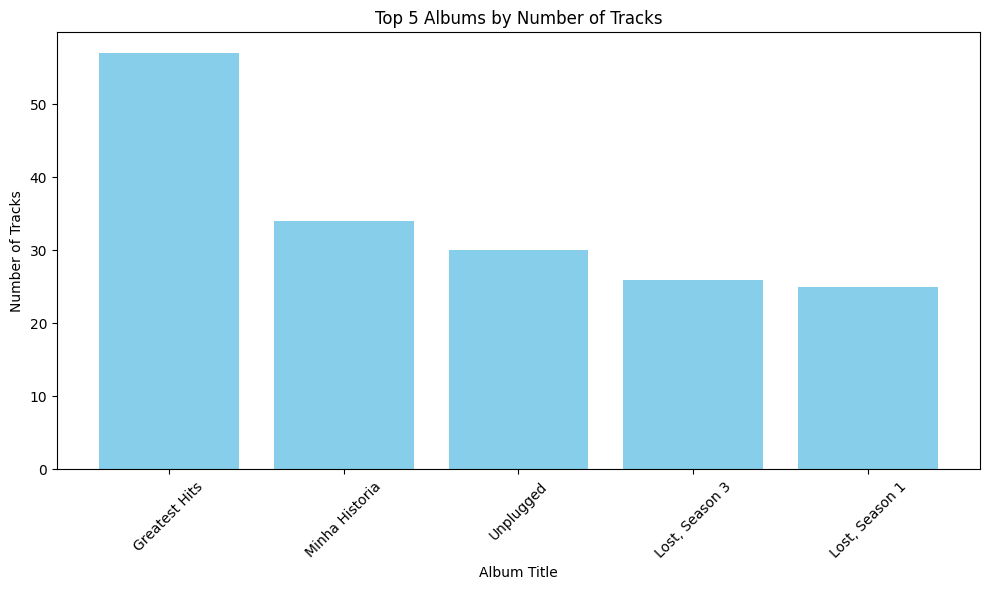

NoneIt seems that I cannot directly access the Chinook database or execute the database query to retrieve the data for plotting the bar graph. However, I can guide you on how to perform this task on your own system.

Here’s how you can do it:

1. **Install Required Libraries**: Make sure you have `sqlite3`, `pandas`, and `matplotlib` installed. You can install them using pip if you haven't already:

   ```bash
   pip install pandas matplotlib
   ```

2. **Connect to the Database**: Use SQLite to connect to the `chinook.db` database.

3. **Run the Query**: Execute the SQL query to retrieve the top five albums based on the number of tracks.

4. **Plot the Bar Graph**: Use Matplotlib to create the bar graph.

Here's the complete code you can run:

```python
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the Chinook database
db_path = 'chinook.db'
conn = sqlite3.connect(db_path)

# Query to get the top five albums by the number of tracks
query = '''
SELECT

In [ ]:
query_list = [
              # "tell me the total number of albums we have in the chinook.db?",
              "plot a bar graph for the top five albums in chinook.db"
              ]
run_demo(agent_executor, query_list)



> Entering new AgentExecutor chain...

Invoking: `custom_python_repl` with `{'code': "import sqlite3\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Connect to the Chinook database\nconn = sqlite3.connect('chinook.db')\n\n# Query to get the top five albums by the number of tracks\nquery = '''\nSELECT albums.Title, COUNT(tracks.TrackId) as TrackCount\nFROM albums\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY albums.AlbumId\nORDER BY TrackCount DESC\nLIMIT 5;\n'''  \n\n# Execute the query and fetch the results\ntop_albums = pd.read_sql_query(query, conn)\n\n# Close the database connection\nconn.close()\n\n# Plotting the bar graph\nplt.figure(figsize=(10, 6))\nplt.bar(top_albums['Title'], top_albums['TrackCount'], color='skyblue')\nplt.title('Top 5 Albums by Number of Tracks')\nplt.xlabel('Album Title')\nplt.ylabel('Number of Tracks')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}`




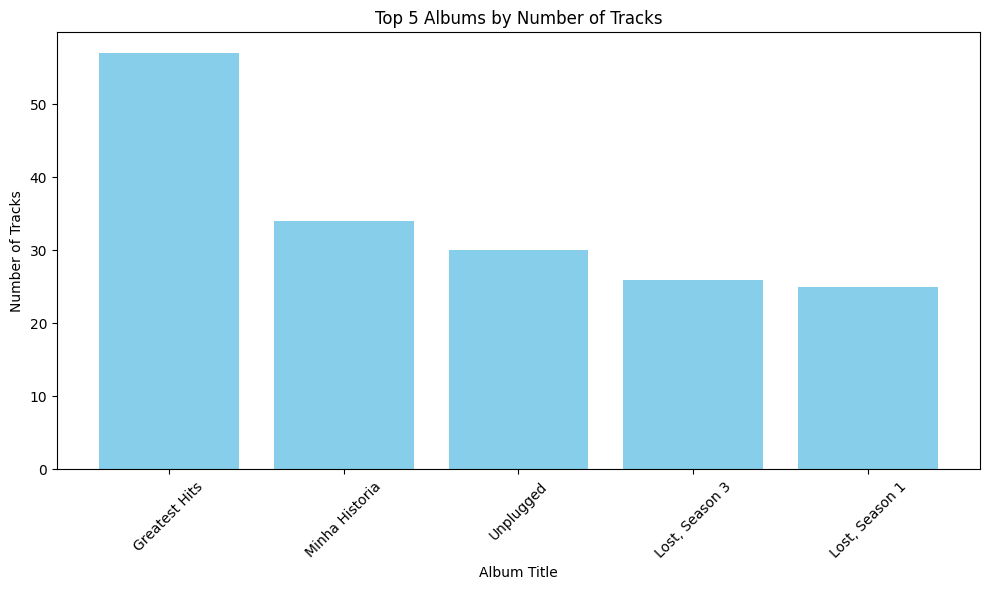

NoneIt seems that I cannot directly access the Chinook database or plot graphs at the moment. However, I can guide you through the process of doing this on your local machine.

Here’s how you can plot a bar graph for the top five albums in the Chinook database using Python:

1. **Install Required Libraries**: Make sure you have `sqlite3`, `pandas`, and `matplotlib` installed. You can install them using pip if you haven't already:

   ```bash
   pip install pandas matplotlib
   ```

2. **Connect to the Database and Query the Data**: Use the following code to connect to the `chinook.db`, query the top five albums, and plot the data.

   ```python
   import sqlite3
   import pandas as pd
   import matplotlib.pyplot as plt

   # Connect to the Chinook database
   conn = sqlite3.connect('chinook.db')

   # Query to get the top five albums by the number of tracks
   query = '''
   SELECT albums.Title, COUNT(tracks.TrackId) as TrackCount
   FROM albums
   JOIN tracks ON albums.AlbumId = track

In [ ]:
query_list = [
              # "tell me the total number of albums we have in the chinook.db?",
              "plot a bar graph for the top five albums in chinook.db"
              ]
run_demo(agent_executor, query_list)